In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import astropy.units as u


from toolkit import get_phoenix_model_spectrum, EchelleSpectrum

standard_path = ('/Users/bmmorris/data/Q3UW04/UT160706/'
                 'BD28_4211.0034.wfrmcpc.fits')
standard_spectrum = EchelleSpectrum.from_fits(standard_path)
target_path = glob('/Users/bmmorris/data/Q1UW09/UT170317/HD266611*wfrmcpc.fits')[0]
target_spectrum = EchelleSpectrum.from_fits(target_path)

def nearest_order(wavelength):
    return np.argmin([abs(spec.wavelength.mean() - wavelength).value
                      for spec in target_spectrum.spectrum_list])

# nearest_order_7055 = nearest_order(7055*u.Angstrom)
# nearest_order_8860 = nearest_order(8860*u.Angstrom)

only_orders = list(range(len(target_spectrum.spectrum_list)))
target_spectrum.continuum_normalize(standard_spectrum,
                                    polynomial_order=10,
                                    only_orders=only_orders,
                                    plot_masking=False)

rv_shifts = u.Quantity([target_spectrum.rv_wavelength_shift(order)
                        for order in only_orders])
median_rv_shift = np.median(rv_shifts)

target_spectrum.offset_wavelength_solution(median_rv_shift)

In [2]:
from toolkit import ModelGrid, bands_TiO
model_grid = ModelGrid()

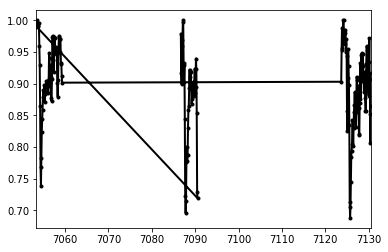

In [3]:
from toolkit import slice_spectrum, concatenate_spectra

spec_band = []
for band in bands_TiO:
    band_order = target_spectrum.get_order(nearest_order(band.core))
    target_slice = slice_spectrum(band_order, band.min, band.max)
    target_slice.flux /= target_slice.flux.max()
    spec_band.append(target_slice)

slices = concatenate_spectra(spec_band)
slices.plot(normed=False, color='k', lw=2, marker='.')

In [4]:
from scipy.optimize import minimize
from toolkit import instr_model, combine_spectra

temp_phot = np.log(4400)
temp_spot = np.log(3800)
spotted_area = 0.5
lam_offset = 0

def minimize_this(p, observed_spectrum, model_grid):
    temp_phot, temp_spot, spotted_area, lam_offset = p
    temp_phot, temp_spot = np.exp([temp_phot, temp_spot])
    combined_interp, residuals = instr_model(temp_phot, temp_spot, 
                                             spotted_area, lam_offset, 
                                             observed_spectrum, model_grid)
    return residuals[0]

In [5]:
# lower_bound = np.array([np.log(4000), np.log(3200), 0, -0.5])
# upper_bound = np.array([np.log(4500), np.log(4000), 1, 0.5])
# bounds = np.c_[lower_bound, upper_bound]
# result = minimize(minimize_this, [temp_phot, temp_spot, spotted_area, lam_offset],
#                   args=(slices, model_grid), bounds=bounds).x
# temp_phot, temp_spot, spotted_area, lam_offset = result
# print("T_phot = {0}, T_spot = {1}, f_s = {2}, offset = {3}"
#       .format(np.exp(temp_phot), np.exp(temp_spot), spotted_area, lam_offset))

# best_model = instr_model(np.exp(temp_phot), np.exp(temp_spot), 
#                          spotted_area, lam_offset, slices, model_grid)[0]
    
# #     combined_broadened.plot(normed=False)
# plt.plot(slices.wavelength, best_model)

# plt.axvline(band.core.value, ls=':', color='gray')
# plt.show()

In [35]:
def random_in_range(min, max):
    return (max-min)*np.random.rand(1)[0] + min

def lnprior(theta):
    temp_phot, delta_temp, spotted_area, lam_offset = theta
    if ((3000 < temp_phot < 6200) and (-1000 < delta_temp < 0) and 
        (0 < spotted_area < 0.5) and (-0.5 < lam_offset < 0.5)):
        return 0.0
    return -np.inf

def lnlike(theta, model_grid, observed_spectrum):
    temp_phot, delta_temp, spotted_area, lam_offset = theta
    temp_spot = temp_phot - delta_temp
    model, residuals = instr_model(temp_phot, temp_spot, spotted_area, lam_offset, 
                                   observed_spectrum, model_grid)
    return -0.5*residuals[0] #-0.5*np.sum((y-model)**2/yerr**2)

def lnprob(theta, model_grid, observed_spectrum):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, model_grid, observed_spectrum)

from emcee import EnsembleSampler
from emcee.interruptible_pool import InterruptiblePool

initp = np.array([4400, -500, 0.1, 0])
ndim, nwalkers = len(initp), 2*len(initp)

pos = []

while len(pos) < nwalkers:
    offsets = np.array([random_in_range(-50, 50), 
                        random_in_range(-50, 50), 
                        random_in_range(-0.05, 0.05), 
                        random_in_range(-0.001, 0.001)])
    realization = initp + offsets
    if np.isfinite(lnprior(realization)):
        pos.append(realization)

pool = InterruptiblePool(processes=4)
sampler = EnsembleSampler(nwalkers, ndim, lnprob, pool=pool,
                          args=(model_grid, slices))

In [41]:
n_steps = 5*nwalkers
sampler.run_mcmc(pos, n_steps);

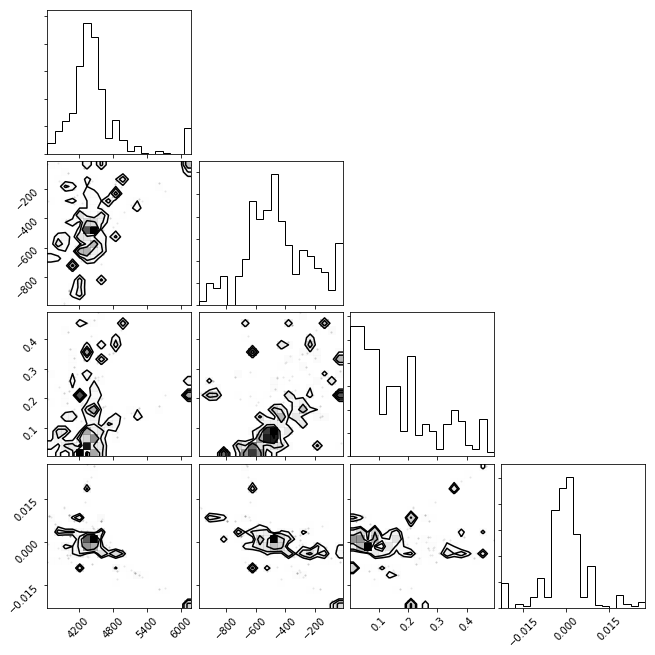

In [42]:
from corner import corner
corner(sampler.flatchain)
plt.show()

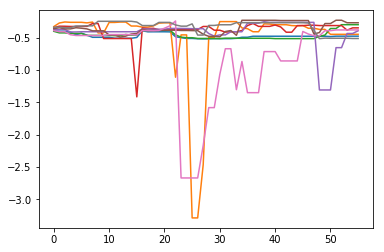

In [43]:
plt.plot(sampler.lnprobability.T)

In [28]:
model, residuals = instr_model(4700, 4200, 0.5, 0, 
                               slices, model_grid)

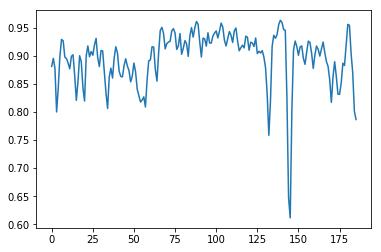

In [34]:
plt.plot(model)